In [65]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import pathlib
import numpy as np
import pandas as pd
from datasets import ObjectDetectionDataSet
from transformations import Clip, ComposeDouble, FunctionWrapperDouble, normalize_01
from utils import get_filenames_of_path, stats_dataset, read_json,save_json
from torch.utils.data import DataLoader
import random
import itertools
import pathlib

# Carga de datos y creación de Dataset

In [2]:
# Directorio de las imagenes y las etiquetas
root = pathlib.Path('../data/ChestXRay8')

# Cargar imágenes y etiquetas
inputs = get_filenames_of_path(root / 'ChestBBImages')
targets = get_filenames_of_path(root / 'ChestBBLabels')

# Ordenar los archivos
inputs.sort()
targets.sort()

# Mapeo de etiquetas a valores enteros
mapping = read_json(pathlib.Path('LabelsMappping.json'))
mappingR = {v:k for k,v in mapping.items()}
mappingR

{0: 'Infiltrate',
 1: 'Atelectasis',
 2: 'Pneumonia',
 3: 'Cardiomegaly',
 4: 'Effusion',
 5: 'Pneumothorax',
 6: 'Mass',
 7: 'Nodule'}

In [3]:
# Transformaciones, ajustar formato, normalizar a m: 0 y std: 1
transforms = ComposeDouble([
    Clip(),
    # AlbumentationWrapper(albumentation=A.HorizontalFlip(p=0.5)),
    # AlbumentationWrapper(albumentation=A.RandomScale(p=0.5, scale_limit=0.5)),
    # AlbumentationWrapper(albumentation=A.VerticalFlip(p=0.5)),
#     FunctionWrapperDouble(np.moveaxis, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

In [4]:
# Contruir el Conjunto de Datos
dataset = ObjectDetectionDataSet(inputs=inputs,
                                 targets=targets,
                                 transform=transforms,
                                 add_dim = False,
                                 use_cache=False,
                                 convert_to_format=None,
                                 mapping=mapping,
                                 tgt_int64=True)

In [5]:
# Visualizar una instancia del conjunto de datos
dataset[22]['x_name'],dataset[22]['y']['labels']

('00000732_005.png', tensor([5, 3]))

# Codificación de etiquetas con función LabelEncoder():

In [6]:
# Configurar semillas de aleatoreidad para reproducibilidad
seed = 42
np.random.seed(seed)
random.seed(seed)

In [7]:
# Organizar la información
xrays = []
labs = []
for i,instance in enumerate(dataset):
    ohc = [mappingR[int(i)] for i in instance['y']['labels']]
    xrays.append(instance['x_name'])
    labs.append(ohc)

X = np.array(xrays) # Nombres de Imagenes
y = np.array(labs) # Etiquetas

La función LabelEncoder() que esta basada en la implementación de Scikit-learn: [Enlace](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [8]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        '''Mapear etiquetas como palabras, a numeros'''
        classes = np.unique(list(itertools.chain.from_iterable(y)))
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        '''Pasar de codificación numérica a codificación OneHot'''
        y_one_hot = np.zeros((len(y), len(self.class_to_index)), dtype=int)
        for i, item in enumerate(y):
            for class_ in item:
                y_one_hot[i][self.class_to_index[class_]] = 1
        return y_one_hot

    def decode(self, y):
        '''Mapear de coficación OneHot a palabras'''
        classes = []
        for i, item in enumerate(y):
            indices = np.where(item == 1)[0]
            classes.append([self.index_to_class[index] for index in indices])
        return classes

    def save(self, fp):
        '''Guardar  el mapeo y codificaciones'''
        with open(fp, 'w') as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [9]:
# Mapear de etiquetas (palabras) a codificación numerica
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

In [10]:
# Obvservar el mapeo realizado
label_encoder.class_to_index

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Effusion': 2,
 'Infiltrate': 3,
 'Mass': 4,
 'Nodule': 5,
 'Pneumonia': 6,
 'Pneumothorax': 7}

In [11]:
# Probar con un ejemplo aleatorio individual el codificador
label_encoder.encode([["Effusion", "Pneumonia"]])

array([[0, 0, 1, 0, 0, 0, 1, 0]])

In [12]:
# Codificar todas las etiquetas del conunto
y = label_encoder.encode(y)
print (y.shape)

(880, 8)


In [13]:
# Verificar una muestra de la codificación al conjunto completo
X[22],y[22]

('00000732_005.png', array([0, 1, 0, 0, 0, 0, 0, 1]))

# Codificación con codigo simplificado

In [14]:
# Codigo simple codificacion numerica desde el objeto Dataset a OneHot Encoding
xrays = []
ohlabs = []
for i,instance in enumerate(dataset):
    oh = np.zeros([8])
#     print(i, instance['y']['labels'])
    ohc = np.array([1 if i in instance['y']['labels'] else 0 for i,j in enumerate(oh)])
    xrays.append(instance['x_name'])
    ohlabs.append(ohc)

xrays = np.array(xrays)
ohlabs = np.array(ohlabs)

In [15]:
# Verificar una muestra de la codificación al conjunto completo
xrays[22],ohlabs[22]

('00000732_005.png', array([0, 0, 0, 1, 0, 1, 0, 0]))

# Partición ingenua 
### (Particiones no equitativas respecto a la distibución de cada clase)

Es necesario limpiar por completo los datos antres de hacer las particiones, específicamente en las características de las que depende la partición. El proceso se realiza de la siguiente forma: 

**preprocesamiento(limpieza global)** --> **particiones** -- > **post-procesamiento(transformaciones locales)**

Para realizar la partición se usaran las etiquetas codificadas a OneHot previamente obtenidas.

In [16]:
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from collections import Counter, OrderedDict

In [17]:
# Tamaños de particiones
train_size = 0.7
val_size = 0.15
test_size = 0.15

Para clasificación multiclase es posible especificar como estratificar las partición añadiento el argumento *stratify* de la función. Sin embargo para probleas de clasificación/detección multietiqueta, es necesario aplicar otras técnicas para crear particiones equilibradas.

In [18]:
# Particion de Entrenamiento - Resto
X_train, X_, y_train, y_ = train_test_split(xrays, ohlabs, train_size=train_size)

In [19]:
print (f"Entrenamiento: {len(X_train)} ({(len(X_train) / len(xrays)):.2f})\n"
       f"Resto: {len(X_)} ({(len(X_) / len(xrays)):.2f})")

Entrenamiento: 616 (0.70)
Resto: 264 (0.30)


In [20]:
# Partición Validación Prueba
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5)

In [21]:
print(f"Entrenamiento: {len(X_train)} ({len(X_train)/len(xrays):.2f})\n"
      f"Validación: {len(X_val)} ({len(X_val)/len(xrays):.2f})\n"
      f"Prueba: {len(X_test)} ({len(X_test)/len(xrays):.2f})")

Entrenamiento: 616 (0.70)
Validación: 132 (0.15)
Prueba: 132 (0.15)


In [22]:
# Verificar muestra despues de la partición
X_train[22],y_train[22]

('00020819_002.png', array([0, 0, 0, 1, 0, 0, 0, 0]))

In [23]:
# Realizar los conteos sobre cada clase después de la partición
counts = {}
counts['train_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_train, order=1) for combination in row)
counts['val_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_val, order=1) for combination in row)
counts['test_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_test, order=1) for combination in row)

In [24]:
# Mostrar el conteo por clase en cada subconjunto
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,"(3,)","(5,)","(7,)","(1,)","(2,)","(4,)","(6,)","(0,)"
train,102,69,61,118,83,110,53,90
val,20,17,10,31,18,24,10,14
test,24,12,8,31,19,19,22,19


En ocasiones, se vuelve difícil realizar la comparación entre las proporciones o distribución de las etiquetas en las diferentes particiones debido a que tienen distintos y variados tamaños o numero de instancias. Para ello es posible realizar un ajuste sobre las estadisticas de las particiones para visualizar de mejor manera su distribución. Lo que se realiza es multiplicar las estadisticas del conjunto de prueba por una taza de ajuste, con lo que logramos escalar las estadisticas para una mejor comparación.

$$\alpha * N_{test} + N_{train}$$

$$\alpha = \frac{N_{train}}{N_{test}}$$

In [25]:
# Ajustar los conteos entre las particiones 
# (poner un factor al subconjunto de validación y prueba solo para comparar mejor la distibución 
# contra los datos en dentrenamiento debido a que tienen una proporción menor de datos)
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))

In [26]:
# Visualización despues del ajuste de conteos entre las particiones
dist_df = pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)
dist_df

,"(3,)","(5,)","(7,)","(1,)","(2,)","(4,)","(6,)","(0,)"
train,102,69,61,118,83,110,53,90
val,93,79,46,144,84,112,46,65
test,112,56,37,144,88,88,102,88


Es posible también ver cuanto se desvian las particiones de datos ingenuas mediante el cómputo de las desviación estándar de cada partición respecto a los conteos de clada clase de la media (partición ideal).

$$\sigma = \sqrt{\frac{x-\hat{x}}{N}}$$

In [27]:
# Calcular la desviación estandar a partir de la partición 'ideal'
np.mean(np.std(dist_df.to_numpy(), axis=0))

11.077771876933605

Algunas de las distribuciones de dichas particiones obtenidas de esta forma suelen no ser son buenas o correctas.

### Gráficas de las distribuciones de las etiquetas con Partición Ingenua.

In [28]:
from PlotUtils import * 

In [29]:
## Realizar los conteos sobre cada clase antes y después de la partición
countsP = {}
countsP["total_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    ohlabs, order=1) for combination in row)
countsP["train_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_train, order=1) for combination in row)
countsP["val_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_val, order=1) for combination in row)
countsP["test_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_test, order=1) for combination in row)

In [30]:
# Visualización despues del ajuste de conteos entre las particioneso
CountsDF = pd.DataFrame({
           "total": countsP["total_counts"],
            "train": countsP["train_counts"],
            "val": countsP["val_counts"],
            "test": countsP["test_counts"]
        }).T.fillna(0)
CountsDF

,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)","(7,)"
total,123,180,120,146,153,98,85,79
train,90,118,83,102,110,69,53,61
val,14,31,18,20,24,17,10,10
test,19,31,19,24,19,12,22,8


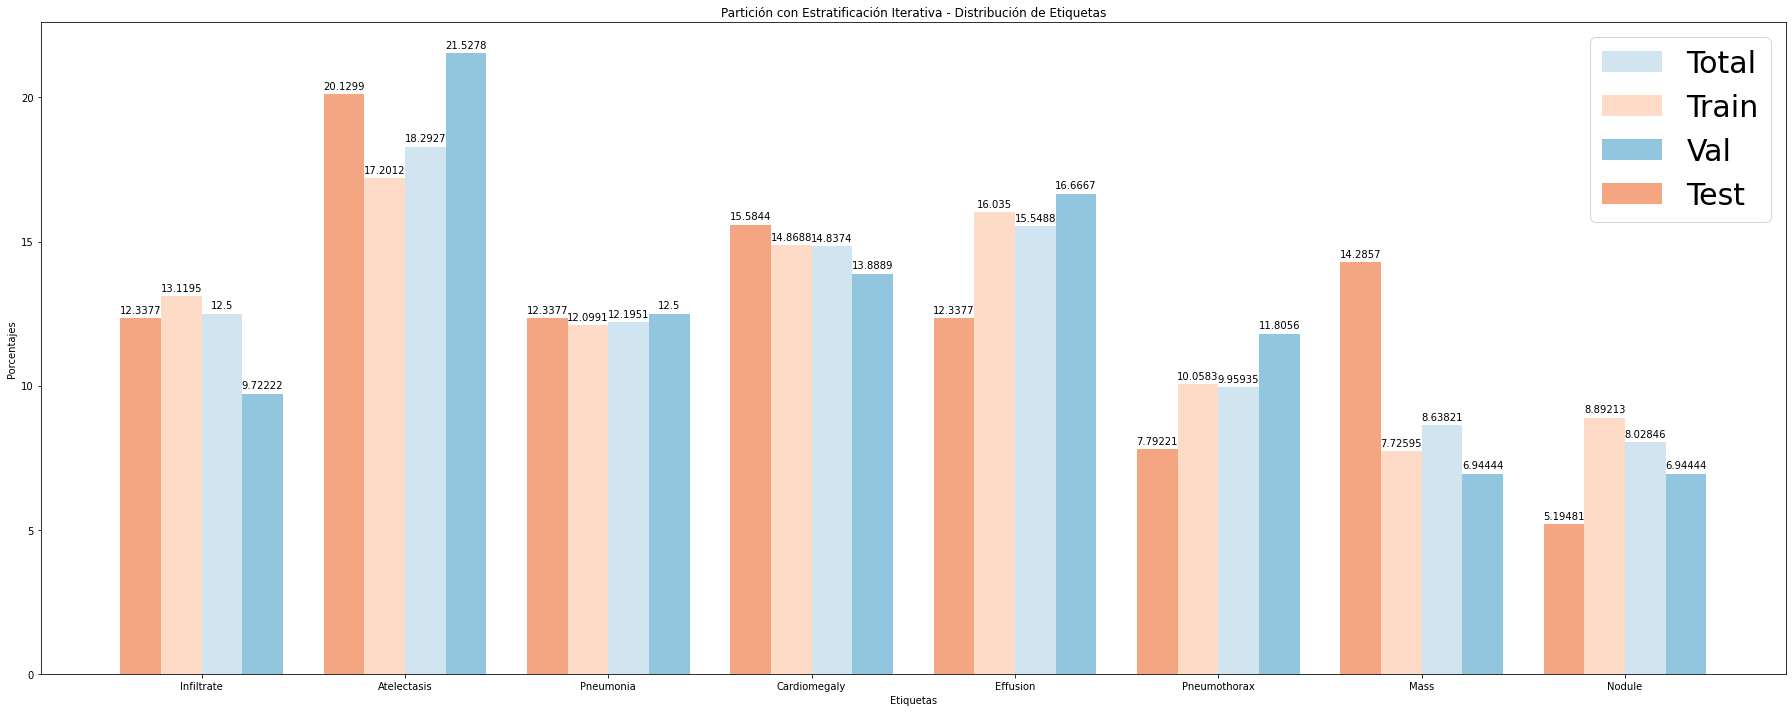

In [31]:
data = {
   "Total": (list(CountsDF.loc['total'])/sum(list(CountsDF.loc['total'])))*100,
    "Train": (list(CountsDF.loc['train'])/sum(list(CountsDF.loc['train'])))*100,
    "Val": (list(CountsDF.loc['val'])/sum(list(CountsDF.loc['val'])))*100,
    "Test": (list(CountsDF.loc['test'])/sum(list(CountsDF.loc['test'])))*100
}
xticks = list(mapping.keys())
title = 'Partición con Estratificación Iterativa - Distribución de Etiquetas'
axlb = ['Etiquetas', 'Porcentajes'] 
groupedBarPlot(data, xticks, title, axislabels = axlb, width = 0.2)

# Partición estratificada
#### (Particiones de datos equilibrados respecto a sus etiquetas y su distribución en el conjunto completo)

Es posible aplicar [estratificación iterativa](http://lpis.csd.auth.gr/publications/sechidis-ecmlpkdd-2011.pdf), mediante la [implementación](http://scikit.ml/api/skmultilearn.model_selection.iterative_stratification.html) disponible en [Scikit-Multilearn](http://scikit.ml/index.html). Esta implementación divide escencialmente cada entrada o instancia en subconjuntos, es decir cada etiqueta es considerada individualmente , y entonces se distribuyen las muestras empezando por la menos 'positiva', hacia las entradas que tienen mas etiquetas.

In [32]:
from skmultilearn.model_selection import IterativeStratification

In [33]:
# Función para ejecutar el algoritmo de iteración estrafificada y obtener particiones equilibradas 
def iterative_train_test_split(X, y, train_size):
    """Custom iterative train test split which 
    'maintains balanced representation with respect 
    to order-th label combinations.'
    """
    stratifier = IterativeStratification(
        n_splits=2, order=1, sample_distribution_per_fold=[1.0-train_size, train_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

In [34]:
# Ejecutar obtención de particiones: Entrenamiento - Validación - Prueba
X_train, X_, y_train, y_ = iterative_train_test_split(
    xrays, ohlabs, train_size=train_size)
X_val, X_test, y_val, y_test = iterative_train_test_split(
    X_, y_, train_size=0.5)

In [35]:
print(f"Entrenameinto: {len(X_train)} ({len(X_train)/len(xrays):.2f})\n"
      f"Validación: {len(X_val)} ({len(X_val)/len(xrays):.2f})\n"
      f"Prueba: {len(X_test)} ({len(X_test)/len(xrays):.2f})")

Entrenameinto: 611 (0.69)
Validación: 136 (0.15)
Prueba: 133 (0.15)


In [36]:
## Realizar los conteos sobre cada clase despues de la partición
counts = {}
counts["train_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_train, order=1) for combination in row)
counts["val_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_val, order=1) for combination in row)
counts["test_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_test, order=1) for combination in row)

In [37]:
# Mostrar el conteo por clase en cada subconjunto
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,"(1,)","(2,)","(0,)","(3,)","(5,)","(6,)","(4,)","(7,)"
train,126,84,86,102,69,59,107,55
val,27,18,19,22,15,13,23,12
test,27,18,18,22,14,13,23,12


In [38]:
# Ajustar los conteos entre las particiones 
# (poner un factor al subconjunto de validación y prueba solo para comparar mejor la distibución 
# contra los datos en dentrenamiento debido a que tienen una proporción menor de datos)
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))

In [39]:
# Visualización despues del ajuste de conteos entre las particioneso
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,"(1,)","(2,)","(0,)","(3,)","(5,)","(6,)","(4,)","(7,)"
train,126,84,86,102,69,59,107,55
val,126,84,88,102,70,60,107,56
test,126,84,84,102,65,60,107,56


In [40]:
# Guardar las proporciones de las particiones
dist_df = pd.DataFrame({
    'train': counts['train_counts'],
    'val': counts['val_counts'],
    'test': counts['test_counts']
}).T.fillna(0)

In [41]:
# Calcular la desviación estandar a partir de la partición 'ideal'
np.mean(np.std(dist_df.to_numpy(), axis=0))

0.5920061378633503

La estratificación iterativa crea particiones mientras intenta mantener una representación balanciada con respesto al nivel de orden de combinaciones de etiquetas. Cuando el parámetro `order=1` es cuado para las particiones iterativas, significa que se mantiene el cuidado en formar una distribución representativa de cada tipo de etiqueta (clase), a través de las particiones. sin embargo, es posible utilizar también [relaciones de etiquetas de alto nivel](https://arxiv.org/abs/1704.08756), y tomar encuenta las distribución de combinaciones de etiquetas. 

In [42]:
# # Split DataFrames
# train_df = pd.DataFrame({"text": X_train, "tags": label_encoder.decode(y_train)})
# val_df = pd.DataFrame({"text": X_val, "tags": label_encoder.decode(y_val)})
# test_df = pd.DataFrame({"text": X_test, "tags": label_encoder.decode(y_test)})
# train_df.head()

In [43]:
# Como parte del código simplificado, regresar de codificación OneHot a palabras 
labsint = [[i for i,item in enumerate(lab) if item == 1] for lab in y_train]
labsint[10],X_train[10]

([3, 5], '00000732_005.png')

### Gráficas de las distribuciones de las etiquetas con Estratificación Iterativa.

In [44]:
from PlotUtils import * 

In [45]:
## Realizar los conteos sobre cada clase antes y después de la partición
countsP = {}
countsP["total_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    ohlabs, order=1) for combination in row)
countsP["train_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_train, order=1) for combination in row)
countsP["val_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_val, order=1) for combination in row)
countsP["test_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_test, order=1) for combination in row)

In [46]:
# Visualización despues del ajuste de conteos entre las particioneso
CountsDF = pd.DataFrame({
           "total": countsP["total_counts"],
            "train": countsP["train_counts"],
            "val": countsP["val_counts"],
            "test": countsP["test_counts"]
        }).T.fillna(0)
CountsDF

,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)","(7,)"
total,123,180,120,146,153,98,85,79
train,86,126,84,102,107,69,59,55
val,19,27,18,22,23,15,13,12
test,18,27,18,22,23,14,13,12


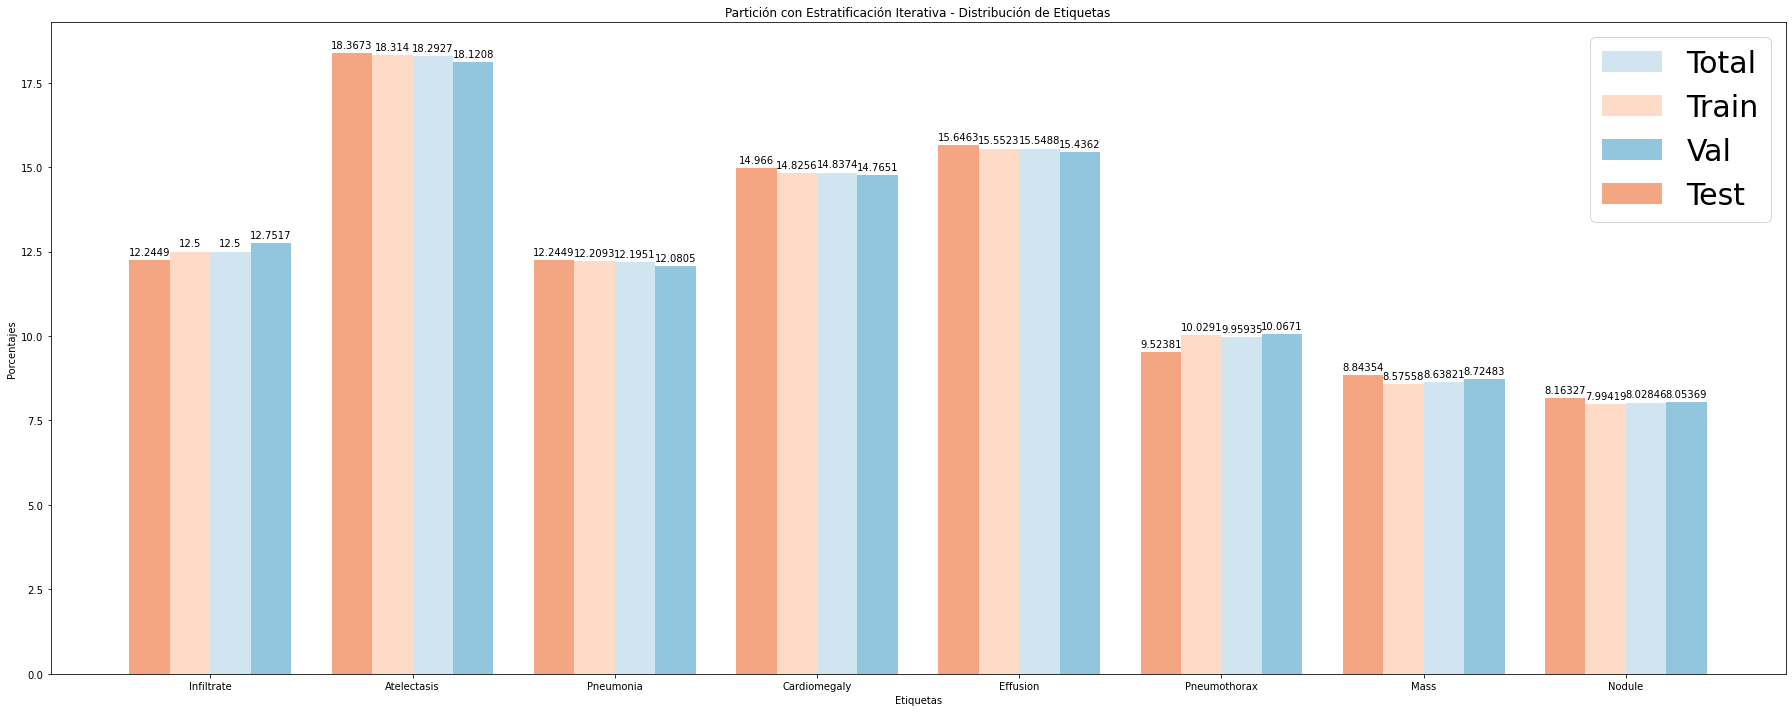

In [47]:
data = {
   "Total": (list(CountsDF.loc['total'])/sum(list(CountsDF.loc['total'])))*100,
    "Train": (list(CountsDF.loc['train'])/sum(list(CountsDF.loc['train'])))*100,
    "Val": (list(CountsDF.loc['val'])/sum(list(CountsDF.loc['val'])))*100,
    "Test": (list(CountsDF.loc['test'])/sum(list(CountsDF.loc['test'])))*100
}
xticks = list(mapping.keys())
title = 'Partición con Estratificación Iterativa - Distribución de Etiquetas'
axlb = ['Etiquetas', 'Porcentajes'] 
groupedBarPlot(data, xticks, title, axislabels = axlb, width = 0.2)

In [68]:
# Guardar los contenidos de las particiones de datos en un diccionario, con un archivo json
split1 = {
 "Train": {ins: lab for ins,lab in zip(X_train.tolist(),[[mappingR[i] for i,item in enumerate(lab) if item == 1] for lab in y_train])},
    "Val": {ins: lab for ins,lab in zip(X_val.tolist(),[[mappingR[i] for i,item in enumerate(lab) if item == 1] for lab in y_val])},
    "Test": {ins: lab for ins,lab in zip(X_test.tolist(),[[mappingR[i] for i,item in enumerate(lab) if item == 1] for lab in y_test])}
}
save_json(split1, pathlib.Path('../DatasetSplits/ChestXRay8/split1.json'))

In [62]:
split1

{'Train': {'00000072_000.png': ['Atelectasis'],
  '00000149_006.png': ['Atelectasis'],
  '00000150_002.png': ['Pneumonia'],
  '00000211_010.png': ['Atelectasis'],
  '00000211_016.png': ['Infiltrate'],
  '00000211_041.png': ['Cardiomegaly'],
  '00000398_003.png': ['Cardiomegaly'],
  '00000468_017.png': ['Atelectasis'],
  '00000506_013.png': ['Pneumonia'],
  '00000583_008.png': ['Atelectasis'],
  '00000732_005.png': ['Cardiomegaly', 'Pneumothorax'],
  '00000744_006.png': ['Atelectasis'],
  '00000756_001.png': ['Cardiomegaly'],
  '00000830_000.png': ['Atelectasis', 'Mass'],
  '00001039_005.png': ['Infiltrate'],
  '00001075_024.png': ['Mass'],
  '00001153_004.png': ['Atelectasis'],
  '00001248_038.png': ['Pneumothorax'],
  '00001320_003.png': ['Atelectasis'],
  '00001369_000.png': ['Cardiomegaly'],
  '00001373_039.png': ['Cardiomegaly'],
  '00001437_012.png': ['Effusion'],
  '00001688_000.png': ['Nodule'],
  '00001836_082.png': ['Atelectasis', 'Mass'],
  '00002059_008.png': ['Cardiomegaly'

In [64]:
help(save_json)

Help on function save_json in module utils:

save_json(obj, path: pathlib.Path)

